In [1]:
# geopython env + mxnet1.6.0 env
import numpy as np
import pandas as pd
from tqdm import tqdm
import imageio
import os
from scipy.stats.stats import pearsonr
from sklearn.metrics import matthews_corrcoef
# import higra as hg

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# mxnet1.6.0 env
import cv2
import mxnet as mx
from mxnet import gluon
from mxnet import autograd
from mxnet import image

import sys
sys.path.append('../../resuneta/src')
sys.path.append('../../resuneta/nn/loss')
sys.path.append('../../resuneta/models')
sys.path.append('../../')
sys.path.append('../MXNet-ResUNeta/')

from resunet_d6_causal_mtskcolor_ddist import *
from resunet_d7_causal_mtskcolor_ddist import *
from datasets import *

# Helper functions

In [3]:
def dice_coef(x, y):
    if type(x).__module__ == 'numpy':
        intersection = np.logical_and(x, y)
        return 2. * np.sum(intersection) / (np.sum(x) + np.sum(y))
    else:
        intersection = mx.ndarray.op.broadcast_logical_and(x, y)
        return 2. * mx.nd.sum(intersection) / (mx.nd.sum(x) + mx.nd.sum(y))

In [4]:
def InstSegm(extent, boundary, t_ext=0.4, t_bound=0.2):
    """
    INPUTS:
    extent : extent prediction
    boundary : boundary prediction
    t_ext : threshold for extent
    t_bound : threshold for boundary
    OUTPUT:
    instances
    """

    # Threshold extent mask
    ext_binary = np.uint8(extent >= t_ext)

    # Artificially create strong boundaries for
    # pixels with non-field labels
    input_hws = np.copy(boundary)
    input_hws[ext_binary == 0] = 1

    # Create the directed graph
    size = input_hws.shape[:2]
    graph = hg.get_8_adjacency_graph(size)
    edge_weights = hg.weight_graph(
        graph,
        input_hws,
        hg.WeightFunction.mean
    )

    tree, altitudes = hg.watershed_hierarchy_by_dynamics(
        graph,
        edge_weights
    )
    
    # Get individual fields
    # by cutting the graph using altitude
    instances = hg.labelisation_horizontal_cut_from_threshold(
        tree,
        altitudes,
        threshold=t_bound)
    
    instances[ext_binary == 0] = -1

    return instances

# Load model

In [5]:
# ==================== USER SETTINGS ==================== #
n_filters = 16
n_classes = 1
hsv_channels = 3
country = 'india'

# === FRANCE MODELS === #
# model_name = 'resunet-d6_2019_10_class-notreeexceptvines_nfilter-16_bs-8_lr-0.001_1x-8x-downsampled/'
# file_name = '../experiments/france/sherrie10k/{}/model.params'.format(model_name)

# === PARTIAL LABELS FRANCE === #
# model_name = 'resunet-d6_2019_10_nfilter-16_bs-8_lr-0.001_4x-downsampled_allfield_n6759/'
# file_name = '../experiments/partial-france/{}/model.params'.format(model_name)

# === AFRICA FINE-TUNED === #
# if country == 'senegal':
#     model_name = 'resunet-d6_sepOctNov_nfilter-16_bs-8_lr-0.001_1x-8x-downsampled_finetuned'
# elif country == 'malawi':
#     model_name = 'resunet-d6_janFebMar_nfilter-16_bs-8_lr-0.001_1x-8x-downsampled_finetuned/'
# elif country == 'ghana-udry':
#     model_name = 'resunet-d6_febJunOct_nfilter-16_bs-8_lr-0.001_1x-8x-downsampled_finetuned/'
# file_name = '../experiments/{}/{}/model.params'.format(country, model_name)
model = ResUNet_d6(_nfilters_init=n_filters, 
                   _NClasses=n_classes,
                   hsv_outchannels=hsv_channels)

# === INDIA FINE-TUNED === #
model_name = 'resunet-d6_Airbus_nfilter-16_bs-8_lr-0.001_fromscratch/'
#'resunet-d6_Airbus_nfilter-16_bs-8_lr-0.001_4x-downsampled-partial_finetuned/'
file_name = '../experiments/india/{}/model.params'.format(model_name)

gpu = 3
model.load_parameters(file_name, ctx=mx.gpu(gpu)) # mx.cpu())

# n_filters = 32
# n_classes = 1
# hsv_channels = 3
# model_name = 'resunet-d7_october_nfilter-32_bs-8_lr-0.001'
# file_name = '../experiments/france/hanAndBurak/{}/model.params'.format(model_name)
# model = ResUNet_d7(_nfilters_init=n_filters, 
#                    _NClasses=n_classes,
#                    hsv_outchannels=hsv_channels)
# gpu = 3
# model.load_parameters(file_name, ctx=mx.gpu(gpu))
# ======================================================= #

depth:= 0, nfilters: 16
depth:= 1, nfilters: 32
depth:= 2, nfilters: 64
depth:= 3, nfilters: 128
depth:= 4, nfilters: 256
depth:= 5, nfilters: 512
depth:= 6, nfilters: 256
depth:= 7, nfilters: 128
depth:= 8, nfilters: 64
depth:= 9, nfilters: 32
depth:= 10, nfilters: 16


# Run India images through model

In [7]:
country = 'india/GeneralBlockchain'

# ==================== USER SETTINGS ==================== #
image_directory = '../data/general_blockchain/airbus_false_color/campaign1/'
batch_size = 8
save_dir = '../results/{}/{}/Airbus/'.format(country, model_name)
# ======================================================= #

image_names = os.listdir(image_directory)
dataset = AirbusNoLabels(image_directory, image_names=image_names, image_suffix='')
dataloader = gluon.data.DataLoader(dataset, batch_size=batch_size)

if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    os.makedirs(os.path.join(save_dir, 'boundary_predictions'))
    os.makedirs(os.path.join(save_dir, 'extent_predictions'))

# initialize metrics
for batch_i, img in enumerate(dataloader):

    img = img.as_in_context(mx.gpu(gpu))
    logits, bound, dist, convc = model(img)

    extent_predicted_classes = mx.nd.ceil(logits[:,[0],:,:] - 0.5)
    boundary_predicted_classes = mx.nd.ceil(bound[:,[0],:,:] - 0.5)

    # Difference out borders
    diff = extent_predicted_classes - boundary_predicted_classes

    for i, diffed in enumerate(diff):
        diffed = np.maximum(diffed.asnumpy(), 0)

        # save predictions
        image_id = image_names[batch_i * batch_size + i]
        np.save(os.path.join(save_dir, 'boundary_predictions/{}.npy'.format(image_id)), bound[i].asnumpy()[0])
        np.save(os.path.join(save_dir, 'extent_predictions/{}.npy'.format(image_id)), logits[i].asnumpy()[0])

#         print(val_names[batch_i * batch_size + i], mcc)
#         fig, ax = plt.subplots(1,5, figsize=(18,4))
#         ax[0].imshow(np.moveaxis(img.asnumpy()[i][:3], 0, -1) / 255.)
#         ax[1].imshow(np.moveaxis(img.asnumpy()[i][3:6], 0, -1) / 255.)
#         ax[2].imshow(np.moveaxis(img.asnumpy()[i][-3:], 0, -1) / 255.)
#         ax[-2].imshow(instanceSeg)
#         ax[-1].imshow(instanceSeg_pred)
#         plt.show()
#     break

## Validation metrics

### MCC

In [10]:
# metrics on partial labels
country = 'india'
# country = 'senegal'
# country = 'malawi'
# country = 'ghana-udry'
codes_to_keep = [1]
batch_size = 8
boundary_kernel_size = (2,2)
ctx_name = 'gpu'
gpu_id = 3

splits_path = '../data/splits/india_planetImagery_splits_20x20.csv'
splits_df = pd.read_csv(splits_path, dtype=str)
splits_df['image_id'] = splits_df['image_id'].str[:4]
splits_df = splits_df.drop_duplicates('image_id')
    
# get all img and labels
all_img_names = []
all_label_names = []
img_dir = '../data/general_blockchain/airbus_false_color/campaign1/'
label_dir = '../data/general_blockchain/airbus_labels/campaign1/'

label_folder_imgs = sorted(os.listdir(label_dir))
for label_name in label_folder_imgs:
    img_name = 'airbus_geowiki_' + label_name.split('_')[-1].split('.')[0] + '.png'
    img_path = os.path.join(img_dir, img_name)
    all_img_names.append(img_path)
    label_path = os.path.join(label_dir, label_name)
    all_label_names.append(label_path)

# split imgs and labels into train/val/test
all_images = pd.DataFrame({'img_path': all_img_names})
all_images['image_id'] = all_images['img_path'].str.split('/').apply(
    lambda x: x[-1]).str.split('.').apply(
    lambda x: x[0]).str.split('_').apply(
    lambda x: x[-1][1:])
all_images = all_images.merge(splits_df[['image_id', 'fold']], on='image_id', how='left')
train_names = all_images[all_images['fold'] == 'train']['img_path'].values
val_names = all_images[all_images['fold'] == 'val']['img_path'].values
test_names = all_images[all_images['fold'] == 'test']['img_path'].values

all_labels = pd.DataFrame({'label_path': all_label_names})
all_labels['image_id'] = all_labels['label_path'].str.split('/').apply(
    lambda x: x[-1]).str.split('.').apply(
    lambda x: x[0]).str.split('_').apply(
    lambda x: x[-1][1:])
all_labels = all_labels.merge(splits_df[['image_id', 'fold']], on='image_id', how='left')
train_names_label = all_labels[all_labels['fold'] == 'train']['label_path'].values
val_names_label = all_labels[all_labels['fold'] == 'val']['label_path'].values
test_names_label = all_labels[all_labels['fold'] == 'test']['label_path'].values

train_dataset = AirbusMasked(
    fold='train', 
    image_names=train_names, 
    label_names=train_names_label, 
    classes=codes_to_keep,
    boundary_kernel_size=boundary_kernel_size)
val_dataset = AirbusMasked(
    fold='val', 
    image_names=val_names, 
    label_names=val_names_label, 
    classes=codes_to_keep,
    boundary_kernel_size=boundary_kernel_size)

train_dataloader = gluon.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_dataloader = gluon.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [11]:
# initialize metrics
if ctx_name == 'cpu':
    ctx = mx.cpu()
else:
    ctx = mx.gpu(gpu_id)

image_mccs = {'train': [], 'val': []}

# validation set
for fold in ['train', 'val']: # 'train', 
    print("Evaluating {} set".format(fold))
    mcc = mx.metric.MCC()
    
    if fold == 'train':
        fold_dataloader = train_dataloader
    elif fold == 'val':
        fold_dataloader = val_dataloader
        
    for batch_i, (img, extent, boundary, distance, hsv, mask) in enumerate(
        tqdm(fold_dataloader)):

        img = img.as_in_context(ctx)
        extent = extent.as_in_context(ctx)
        boundary = boundary.as_in_context(ctx)
        distance = distance.as_in_context(ctx)
        hsv = hsv.as_in_context(ctx)
        mask = mask.as_in_context(ctx)
        nonmask = mx.nd.ones(extent.shape).as_in_context(ctx)

        logits, bound, dist, convc = model(img)
        
        # update metrics based on every batch
        # mask out unlabeled pixels            
        logits_reshaped = logits.reshape((logits.shape[0], -1))
        extent_reshaped = extent.reshape((extent.shape[0], -1))
        mask_reshaped = mask.reshape((mask.shape[0], -1))
        
        nonmask_idx = mx.np.nonzero(mask_reshaped.as_np_ndarray())
        nonmask_idx = mx.np.stack(nonmask_idx).as_nd_ndarray().as_in_context(ctx)
        logits_masked = mx.nd.gather_nd(logits_reshaped, nonmask_idx)
        extent_masked = mx.nd.gather_nd(extent_reshaped, nonmask_idx)
        
        probabilities = mx.nd.stack(1 - logits_masked, logits_masked, axis=1)
        mcc.update(extent_masked, probabilities)

        for i in range(img.shape[0]):
            if np.sum(mask[i][0].asnumpy()) == 0:
                image_mccs[fold].append(np.nan)
            else:
                nonmask_idx = mx.np.nonzero(mask[i][0].as_np_ndarray())
                nonmask_idx = mx.np.stack(nonmask_idx).as_nd_ndarray().as_in_context(ctx)
                logits_masked = mx.nd.gather_nd(logits[i][0], nonmask_idx)
                extent_masked = mx.nd.gather_nd(extent[i][0], nonmask_idx)
                logits_masked_np = np.array(logits_masked.asnumpy() > 0.5, dtype='uint8')
                extent_masked_np = extent_masked.asnumpy()

                img_mcc = matthews_corrcoef(extent_masked_np, logits_masked_np)
                image_mccs[fold].append(img_mcc)
                
    print("  MCC = {}".format(mcc.get()[1]))

  0%|          | 0/142 [00:00<?, ?it/s]

Evaluating train set


  4%|▍         | 6/142 [00:05<02:07,  1.06it/s]/home/swang222/anaconda3/envs/mxnet1.6.0/lib/python3.6/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
  0%|          | 0/35 [00:00<?, ?it/s]

  MCC = 0.5096726203131252
Evaluating val set


100%|██████████| 35/35 [00:32<00:00,  1.09it/s]

  MCC = 0.5074992290015253


In [22]:
results = pd.DataFrame({
    'image_path': list(train_names) + list(val_names),
    'mcc': image_mccs['train'] + image_mccs['val'],
    'fold': ['train'] * len(train_names) + ['val'] * len(val_names)
})
results['image_id'] = results['image_path'].str.split('/').apply(
    lambda x: x[-1]).str.split('C').apply(lambda x: x[-1]).str.split('.').apply(lambda x: x[0])
results['month'] = results['image_path'].str.split('/').apply(lambda x: x[-2])

In [24]:
results[results['fold'] == 'val'].mean()

mcc         0.507325
image_id         inf
dtype: float64

In [25]:
results.to_csv('../results/india/GeneralBlockchain/{}/results_direct_transfer.csv'.format(model_name), index=False)

In [23]:
results.sort_values(by='mcc', ascending=False).head()

,image_path,mcc,fold,image_id,month
1090,../data/general_blockchain/airbus_false_color/...,0.916667,train,1914,campaign1
644,../data/general_blockchain/airbus_false_color/...,0.838017,train,1046,campaign1
306,../data/general_blockchain/airbus_false_color/...,0.833851,train,0486,campaign1
582,../data/general_blockchain/airbus_false_color/...,0.827062,train,0956,campaign1
489,../data/general_blockchain/airbus_false_color/...,0.825383,train,0787,campaign1


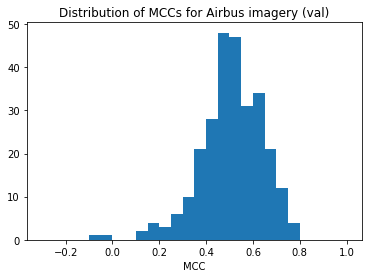

0.5199306890317704


In [34]:
plt.hist(results[results['fold'] == 'val'].groupby('image_id').max()['mcc'], bins=np.linspace(-0.3,1.0,27))
plt.title('Distribution of MCCs for Airbus imagery (val)')
plt.xlabel('MCC')
plt.show()
print(results.groupby('image_id').max()['mcc'].median())

In [12]:
results.groupby('month').mean()

,mcc
month,
2020_07,0.199603
2020_08,0.185679
2020_09,0.238428
2020_10,0.285297
2020_11,0.285338
2020_12,0.282393
2021_01,0.268612
2021_02,0.277228
2021_03,0.265187


In [10]:
# pc1 = pd.read_csv('../results/senegal/resunet-d6_2019_10_class-notreeexceptvines_nfilter-16_bs-8_lr-0.001_1x-8x-downsampled/image_PC1.csv')
# pc1 = pd.read_csv('../results/malawi/resunet-d6_2019_10_class-notreeexceptvines_nfilter-16_bs-8_lr-0.001_1x-8x-downsampled/image_PC1.csv')
pc1 = pd.read_csv('../results/ghana/udry/resunet-d6_2019_10_class-notreeexceptvines_nfilter-16_bs-8_lr-0.001_1x-8x-downsampled/image_PC1.csv')
pc1['image_id'] = pc1['image_id'].astype(str).str.zfill(5)

In [11]:
merged = results.merge(pc1, on=['image_id', 'month'], how='left')

In [12]:
merged.head()

,image_path,mcc,fold,image_id,month,image_name,PC1
0,../data/planet/ghana/udry/monthly_mosaics_rena...,0.322916,train,00272,2017_02,00272_2017_02.tif,-0.250673
1,../data/planet/ghana/udry/monthly_mosaics_rena...,0.500312,train,00273,2017_02,00273_2017_02.tif,0.126828
2,../data/planet/ghana/udry/monthly_mosaics_rena...,0.429873,train,00381,2017_02,00381_2017_02.tif,1.569054
3,../data/planet/ghana/udry/monthly_mosaics_rena...,0.259320,train,00382,2017_02,00382_2017_02.tif,0.026403
4,../data/planet/ghana/udry/monthly_mosaics_rena...,0.537135,train,00383,2017_02,00383_2017_02.tif,0.850485


## Visualize results

### Multi-month model Sherrie 10k

In [ ]:
'../data/planet/india/GeneralBlockchain/extent_labels/'

In [22]:
extent_label.shape

(211, 211)

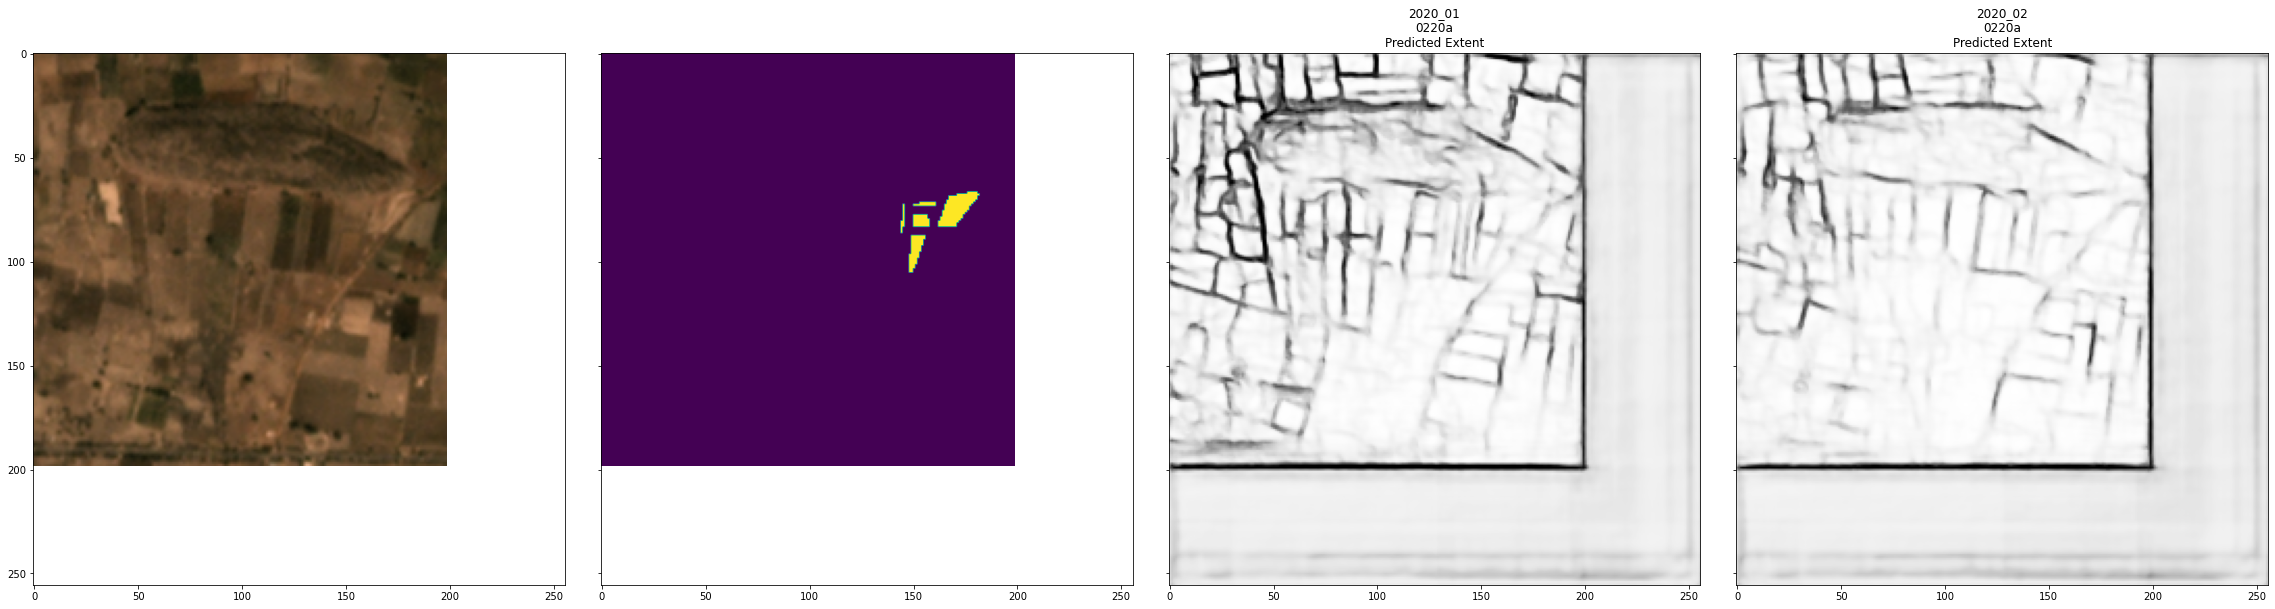

In [23]:
country = 'india/GeneralBlockchain'
model_name = 'resunet-d6_2019_10_nfilter-16_bs-8_lr-0.001_4x-downsampled_allfield_n6759/'
results_dir = '../results/{}/{}/planet/'.format(country, model_name)
planet_dir = '../data/planet/{}/monthly_mosaics_renamed_clipped_merged/'.format(country)
label_dir = '../data/planet/{}/extent_labels/'.format(country)
month_dirs = sorted(os.listdir(planet_dir))

img_csv = pd.read_csv('../data/planet/india/GeneralBlockchain/bbox_india_GB_v1.csv', dtype=str)
random_image_name = np.random.choice(img_csv['image_id'].values)
planet_img = imageio.imread(os.path.join(planet_dir, month, random_image_name + '_' + month + '.tif'))
extent_label = imageio.imread(os.path.join(label_dir, random_image_name + '.png'))

fig, ax = plt.subplots(1, 4, figsize=(32,8), sharex=True, sharey=True)
ax[0].imshow(planet_img)
ax[1].imshow(extent_label)
for m, month in enumerate(month_dirs):
    example_extent = np.load(os.path.join(results_dir, month, 'extent_predictions/{}.npy'.format(random_image_name)))
    example_boundary = np.load(os.path.join(results_dir, month, 'boundary_predictions/{}.npy'.format(random_image_name)))

    ax[m+2].imshow(example_extent, vmin=0, vmax=1, cmap='Greys_r')
    ax[m+2].set_title('{}\n{}\nPredicted Extent'.format(month, random_image_name))

plt.tight_layout()
plt.show()

In [18]:
planet_img.shape

(212, 212, 4)

In [8]:
# country = 'ghana/udry'
# model_name = 'resunet-d6_aprJulOctSeparate_class-notreeexceptvines_nfilter-16_bs-8_lr-0.001_4x-downsampled/'
# results_dir = '../results/{}/{}/planet/'.format(country, model_name)
# planet_dir = '../data/planet/{}/monthly_mosaics_renamed_clipped_merged/'.format(country)
# month_dirs = sorted(os.listdir(planet_dir))
# random_image_name = '00005'

# t_ext = 0.5
# t_bound = 0.1

# fig, ax = plt.subplots(2, 6, figsize=(36,12))
# for m, month in enumerate(month_dirs):
# #     example_img = imageio.imread(os.path.join(image_dir, month, '{}_{}.tif'.format(image_id, month)))[:256,:256,:3]
#     example_extent = np.load(os.path.join(results_dir, month, 'extent_predictions/{}.npy'.format(random_image_name)))
#     example_boundary = np.load(os.path.join(results_dir, month, 'boundary_predictions/{}.npy'.format(random_image_name)))
    
#     instances = InstSegm(example_extent, example_boundary, t_ext=t_ext, t_bound=t_bound)

#     # map instances to better range for plotting
#     unique_instances = sorted(np.unique(instances))
#     n_instances = len(unique_instances)
#     instance_map = {x: i for i, x in enumerate(unique_instances)}
#     def map_values(x):
#         return instance_map[x]
#     instances_mapped = np.array(list(map(map_values, instances.flatten()))).reshape( 
#         instances.shape[0], instances.shape[1])
    
#     i = m // 6
#     j = m % 6
#     ax[i,j].imshow(instances_mapped, vmin=0, vmax=n_instances+1, cmap='tab20')
#     ax[i,j].set_title('{}\nPredicted Instances'.format(month))

# plt.tight_layout()
# plt.show()

## Which month has the best imagery?

In [9]:
# country = 'ghana/udry'
# planet_dir = '../data/planet/{}/monthly_mosaics_renamed_clipped_merged/'.format(country)
# months = sorted(os.listdir(planet_dir))
# img_csv = pd.read_csv('../data/planet/{}/bbox10.csv'.format(country), dtype=str)
# img_name = np.random.choice(img_csv['image_id'].values)

# ncols = 6
# nrows = len(months) // ncols
# fig, ax = plt.subplots(nrows, ncols, figsize=(21, 7))
# for k, month in enumerate(months):
#     i = k // ncols
#     j = k % ncols
#     img = imageio.imread(os.path.join(planet_dir, month, img_name+'_'+month+'.tif'))
#     ax[i,j].imshow(img[:256,:256])
#     ax[i,j].set_yticklabels([])
#     ax[i,j].set_xticklabels([])
#     if j == 0:
#         ax[i,j].set_ylabel("Image {}".format(img_name))
#     ax[i,j].set_title("Month: {}".format(month.split('_')[-1]))
    
# plt.show()